# Project Goals
The goal of this project is to perform a sentiment analysis on search results from Google recommendations, such as "Starbucks Oslo" or "Elkjøp Storo." The main idea is that relying solely on star ratings is an inconsistent way of measuring customer satisfaction for a given place. Therefore, I chose to implement sentiment analysis to get an idea of whether most reviews are, for example, "frustrated," "positive," or "negative."

For each search, the Google Places API will return up to five results—for instance, five Starbucks locations in Oslo. I will then perform a sentiment analysis on each place and conduct an overall NLP-based (Natural Language Processing) evaluation of all the places to decide on the best overall option.

---

# Approach

## Logical Flow
This project utilizes a sequential logical flow, resembling a pipeline or Chain of Thought (CoT).

We first start by gathering the place IDs (a unique identifier for each business location) and peripheral data (name and address) using the Google Places API. This will give us up to five relevant places based on our search term (such as "Starbucks Oslo").

Then, we obtain more data about each place using another Places API based on the place IDs. Here, we get access to the reviews, as well as ratings and additional peripheral data.

At this point, we are ready to start our NLP sequence.

- **Step One:** Loop through every place and every review for each place, writing a short sentiment summary of each review and labeling each review with single-word descriptors such as "happy," "frustrated," "dirty," etc. This is the first step in our CoT. We also assign a 0-10 rating to each review, where 0 is highly negative and 10 is highly positive.
- **Step Two:** Loop through every place and generate a short sentiment review, as well as sentiment labels for each place based on all the reviews for that place. This is the second step in our CoT and serves as a summarization of all the reviews for a single place. We then calculate the average rating for the place, which is done manually (i.e., outside the LLM).
- **Step Three:** Decide on the best place by evaluating each summary, the labels for each place, and the average rating. The LLM decides on the best place holistically, rather than simply selecting the one with the highest rating. The result is presented as a print statement containing a short summary of why this is the best place, along with the rating and labels.

---

## Code Structure
The code is structured in pairs of blocks. The first block contains the method definitions (e.g., `get_place_id(place_name)`), and the following block executes these methods with the necessary loops (e.g., `get_place_ids('Starbucks')`). The second block also prints the output.

**Please use the variable `PLACE_OF_INTEREST` in the next codeblock to select your location. Other than that, you are set.**
- First, we gather the place IDs using `get_place_ids`.
- Then, we get the reviews using `get_reviews`.
- Next, we label each review with sentiments using `sentiment_grade_review` (this method makes a lot of API calls and takes a couple of minutes).
- After that, we perform sentiment grading for each place by summarizing the sentiments of each review using `make_overall_sentiment_rating`.
- Finally, we decide on the best place by comparing the sentiments of each place using `select_best_place`.

---

# Challenges

## API Costs and Speed
This pipeline makes a lot of API calls, with one run typically taking two to three minutes. This is both slow and expensive. A possible solution might be to use threading for improved performance and to reduce the amount of text being processed. For instance, one could try to select the best place by just looking at the labels, disregarding the summaries. Experimenting with lighter, cheaper models might also be a reasonable approach.

## Hallucinations
During testing, I observed that the average score of some places was negative—for example, -3.7 on a 0-10 scale. This is a misjudgment by the model, as it sometimes interprets -10 as highly negative, 0 as neutral, and 10 as positive, even though the instructions specify that 0 is negative and 10 is positive.

## Old Reviews
Reviews that are old (e.g., 3+ years) are not as relevant. Ideally, I should have filtered these out.

## Small Dataset
Being limited to just five reviews per API call to the Google Places API is not much; ideally, one would have a larger dataset per place, say the 30 newest reviews. This would be possible to implement, but comes at the cost of higher API costs to OpenAI, as well as longer run times. If I were to implement more reviews per place, multithreading would be necessary.

---

# Key Takeaways

## Vast Amounts of Unused NLP-Based Data
There is a lot of unstructured (natural language) data waiting to be exploited. Such data is often user-generated—in the form of reviews, complaints, comments, etc.—and is extremely valuable for the business since it comes directly from the users.

Other exciting applications may include advanced FAQ bots, sophisticated RAG-chains based on internal company data, and more. For an implementation of RAG, please try out my ChatGPT + Google Drive application, which creates an embedding store of your Google Drive on *drivesearcher.com*.

## Modern LLMs Are Incredibly Good at Context
The first LLMs, such as ChatGPT 3.0, were good at generating general text but struggled to understand user instructions (such as prompt tuning) and context. Modern LLMs, on the other hand, are highly adaptable and understand context in a meaningful way, making applications like the one showcased below much more useful.

## Chain of Thought
This script should have been built in LangChain or LangGraph, for that matter. As demonstrated by OpenAI, a chain of thought is a highly efficient way of enhancing a model's performance. Instead of using a single chat instance that tells the model, "There are 10 reviews for each place. Here are 5 places; select the best one," it is better to break up the process into a chain of thought, similar to how humans would process the data mentally. This is the approach I have taken:
- **First:** Mark the sentiment of each review.
- **Second:** Mark the sentiment of each place based on the reviews.
- **Third:** Decide on the best place based on sentiment.

For a production environment, I would definitely have used LangChain, as it simplifies typing and data management, but due to the extra setup overhead, I decided to skip it for now.

## Typing
My biggest challenge along the way was not understanding the JSON structure of the previous method. For instance, I spent a lot of time going back and forth trying to determine where the name of the place was stored. If I had used typing from the start, the development process would have been much easier and quicker.

---

# Using LLMs versus Traditional Approaches
As we can see in the bottom-most code block, based solely on star rating one would want to go to Starbucks located in Nedre Storgate 6, 3015 Drammen, Norway. This is different from the model's recommendation which (during this test run) was Starbucks at Jernbanetorget, citing its good customer service and convenient location.

Also, based on the graph below, the sentiment analysis is quite in line with the star ratings for each place, except for some outliers. These are probably places where the LLM sniffs out good/bad sentiment, amid bad/good star ratings.

---

# Findings and Potential Improvements
Next time, I will definitely use typing as knowing where your data is saves you so much time on debugging. A framework like LangGraph or LangChain, which has a **state**, would be really useful as each method in my implementation can be viewed upon as data enriching.

A large pitfall for me, which I encountered head-on, was the selection of models. I went in with the thought "newer is better" and used the GPT-4.5 preview. After some amount of testing, I hit my 5 USD API limit, which was astonishing considering the low volume of tokens. Upon inspecting the pricing page of OpenAI, I realized that GPT-4.5 is 35 times as expensive as GPT-4 and over 100 times as expensive as GPT-3-mini. Selecting the model is extremely important, as they are costly, but you need to balance cost with a capable model. From my testing, I found GPT-4 to be the sweet spot, delivering consistent results.

Slow code is not bad, but fast code is better. In addition to using multithreading, one could try to limit API calls to OpenAI by sending multiple reviews for sentiment analysis as a single context/message. There are some risks here, however, mainly that the sentiment from one review spills into the next, making the model confuse the reviews with one another.

Lastly, using a fine-tuned model for sentiment analysis instead of the stock GPT-4 would most likely yield more consistent results, compared to just prompt-tuning. However, to thoroughly test the performance advantages one would need a larger dataset.

Summarising, I find my approach to be quite good as it consistently selects the places with the best sentimental reviews, which are not always the places with the highest rating. Also, the model is consistent. That is, it is giving me the same result for the same query every time I run it.

In [47]:
#load env vars
import os
from dotenv import load_dotenv

# Load variables from .env file
load_dotenv()

PLACES_API_KEY = os.getenv("PLACES_API_KEY")
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
OPENAI_MODEL = os.getenv("OPENAI_MODEL")
PLACE_OF_INTEREST = "Starbucks"

In [48]:
#get the necesary data from the GOOGLE PLACES API
import requests

#use semantic search to get the PLACE_ID, then fetch the reviews

def get_place_ids(input_text='starbucks'):
    #fields = "name,rating,place_id"

    url = (
        f"https://maps.googleapis.com/maps/api/place/textsearch/json?"
        f"query={input_text}&key={PLACES_API_KEY}"
    )

    # Make the GET request
    response = requests.get(url)
    data = response.json()

    places = []
    for place in data.get("results", []):
        places.append({
            "name": place.get("name"),
            "rating": place.get("rating"),
            "place_id": place.get("place_id"),
            "address": place.get("formatted_address")
        })
        

    return places

In [49]:
places = get_place_ids(PLACE_OF_INTEREST)
# print(places)

In [50]:
from urllib.parse import urlencode
#fetch the reviews based on place id

parameters = ['rating', 'reviews', 'types']
fields_str = ','.join(parameters) 

base_url = "https://maps.googleapis.com/maps/api/place/details/json"

def get_reviews(places :list):
    places_with_reviews = {}

    for place in places:
        place_id = place['place_id']
        name = place['name']
        address = place['address']
        rating = place['rating']

        query_params = {
            "fields": fields_str,
            "place_id": place_id,
            "key": PLACES_API_KEY
        }
        url = f"{base_url}?{urlencode(query_params)}"

        response = requests.get(url)
        data = response.json()
        print(data)

        #distill the necesary data
        result = data['result']
        reviews :list= result['reviews']

        #extract the necesary data from the reviews
        #add an ID (index) for easier managment
        formatted_reviews = []
        for i in range(len(reviews)):
            text = reviews[i]['text']
            formatted_reviews.append({
                "id": place_id,
                "index": i,
                "rating": rating,
                "text": text ,
                "name": name,
                "address": address
            })

        places_with_reviews[place_id]=formatted_reviews
    
    return places_with_reviews

In [51]:
places_with_reviews = get_reviews(places=places)
# print(places_with_reviews)

{'html_attributions': [], 'result': {'rating': 3.7, 'reviews': [{'author_name': 'Nikolai Sandved', 'author_url': 'https://www.google.com/maps/contrib/100499641657645166106/reviews', 'language': 'en', 'original_language': 'en', 'profile_photo_url': 'https://lh3.googleusercontent.com/a-/ALV-UjUK0TC0pligS7HuCp7F-5enIuPeo0imWFViKjGnidmGlF8A1eNe1Q=s128-c0x00000000-cc-rp-mo-ba7', 'rating': 3, 'relative_time_description': '6 years ago', 'text': 'It’s great to have Starbucks in the Oslo city mall. Unhappily the place is not well maintained. They used more than 15 mins to clean tables in a place with a lot of people coming and going.\n\nThe vanilla cream Frappuccino tasted fantastic according to the kid. The caramel pecan brownies was also fabulous.\n\nThe prices at the Norwegian Starbucks is way too high.', 'time': 1540053906, 'translated': False}, {'author_name': 'Katarina Sinkovic', 'author_url': 'https://www.google.com/maps/contrib/111339444749877101338/reviews', 'language': 'en', 'original

In [52]:
#invoke the llm, prompt-tune it to become a sentiment analasysist
from pydantic import BaseModel
from openai import OpenAI

client = OpenAI()

system_prompt = """
    Asses the sentiment of the review below.
    Make a short, couple sentence summary of the sentiment. 
    Add some single-word labels that describe teh sentiment.
    Add a score of 0-10 where 10 is highly positive sentiment, while 0 is highly negative"
"""

#summary: a short textual description of the sentiment
#label: a one-word description of the sentiment such as "happy", "sad", "disappointed", "delucional"
class Sentiment(BaseModel):
    summary: str
    labels: list[str]
    score: int

#returns a set of reviews
def sentiment_grade_review(reviews :list):

    #loop through each review and store the data in llm_responses
    llm_responses = []

    for review in reviews:
        place_id = review['id']
        index = review['index']
        rating = review['rating']
        text = review['text']
        name = review['name']
        address = review['address']

        print(f"working on review {index+1}/{len(reviews)}")

        #skip the reviews with no text
        if not text:
            pass

        completion = client.beta.chat.completions.parse(
            model=OPENAI_MODEL,
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": text},
            ],
            response_format=Sentiment,
        )
        event = completion.choices[0].message.parsed

        llm_responses.append({
            "id": place_id,
            "index": index,
            "name": name,
            "address": address,
            "rating": rating,
            "text": text,
            "summary": event.summary,
            "labels": event.labels,
            "score": event.score
        })
    
    return llm_responses




In [53]:
places_with_sentiment = {}
for index, place_id in enumerate(list(places_with_reviews.keys())):  
    print(f"\n Working on place {index+1}/{len(places_with_reviews.keys())}")
    reviews = places_with_reviews[place_id] #list of reviews

    sentiments =  sentiment_grade_review(reviews=reviews)
    places_with_sentiment[place_id] = sentiments

# print(places_with_sentiment)




 Working on place 1/9
working on review 1/5
working on review 2/5
working on review 3/5
working on review 4/5
working on review 5/5

 Working on place 2/9
working on review 1/5
working on review 2/5
working on review 3/5
working on review 4/5
working on review 5/5

 Working on place 3/9
working on review 1/5
working on review 2/5
working on review 3/5
working on review 4/5
working on review 5/5

 Working on place 4/9
working on review 1/5
working on review 2/5
working on review 3/5
working on review 4/5
working on review 5/5

 Working on place 5/9
working on review 1/5
working on review 2/5
working on review 3/5
working on review 4/5
working on review 5/5

 Working on place 6/9
working on review 1/5
working on review 2/5
working on review 3/5
working on review 4/5
working on review 5/5

 Working on place 7/9
working on review 1/5
working on review 2/5
working on review 3/5
working on review 4/5
working on review 5/5

 Working on place 8/9
working on review 1/5
working on review 2/5
wo

In [54]:
system_prompt = f"""
    Based on the labels and summaries below you are to make an overall sentimentanalysis.
    Write a short summary describing the general sentiment.
    Add the most common sentiment-labels
"""

class OverallSentiment(BaseModel):
    summary: str
    labels: list[str]


def make_overall_sentiment_rating(sentiments :list):
    number_of_reviews = len(sentiments)
    total_score = 0
    summaries = ''
    total_labels = []

    for s in sentiments:
        # place_id = s['id']
        # index = s['index']
        # rating = s['rating']
        # text = s['text']
        summary = s['summary']
        labels = s['labels']
        score = s['score']

        total_score += score
        summaries += "\n\n\n" + summary
        total_labels.extend(labels)

    avg_score = round(total_score / number_of_reviews, 1)

    prompt = summaries + "\nLabels: " + ", ".join(total_labels)

    #pass to llm
    completion = client.beta.chat.completions.parse(
        model=OPENAI_MODEL,
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": prompt},
        ],
        response_format=OverallSentiment,
    )
    event = completion.choices[0].message.parsed

    summary = event.summary
    labels = event.labels

    summarised_review = {
        "name": sentiments[0]['name'], #extraxt the name and adr from the first review
        "address": sentiments[0]['address'],
        "summary": summary,
        "labels": labels,
        "avg_score": avg_score,
    }

    return summarised_review
        

In [55]:
summarised_reviews = {}
for index, (place_id, sentiment) in enumerate(places_with_sentiment.items(), start=1):
  print(f"working on summarising reviews for place {index}/{len(places_with_sentiment.keys())}")
  pws = places_with_sentiment[place_id]
  summarised_review = make_overall_sentiment_rating(sentiments=pws)
  summarised_reviews[place_id] = summarised_review

# print(summarised_reviews)

working on summarising reviews for place 1/9
working on summarising reviews for place 2/9
working on summarising reviews for place 3/9
working on summarising reviews for place 4/9
working on summarising reviews for place 5/9
working on summarising reviews for place 6/9
working on summarising reviews for place 7/9
working on summarising reviews for place 8/9
working on summarising reviews for place 9/9


In [56]:
system_prompt = f"""
    Based on the sentiment summaries, labels and average score below you are to decide on the best place. Write a short summary about why this is the best place. 
    In the summary, include the average rating. Add labels describing the place.
"""


class Bestplace(BaseModel):
    summary: str
    labels: list[str]


def select_best_place(summarised_reviews :dict):
    
    prompt = ''
    for place_id in summarised_reviews.keys():
        place = summarised_reviews[place_id]
        summary = place['summary']
        labels = place['labels'] #list
        name = place['name']
        address = place['address']
        avg_score = place['avg_score']

        prompt += f"\n\n\n Name of the place: {name} \n Address: {address} \n Average 0-10 score, where 10 is highly positive is {avg_score} \n Summary: {summary} \n Labels: {labels}"

    completion = client.beta.chat.completions.parse(
    model=OPENAI_MODEL,
    messages=[
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": prompt},
    ],
    response_format=OverallSentiment,
    )

    event = completion.choices[0].message.parsed
    return event

In [57]:
best_place = select_best_place(summarised_reviews=summarised_reviews)
summary = best_place.summary
labels = best_place.labels

print(f"""
{summary}
\n\n
This place has the following sentiment labels:\n
{", ".join(labels)}
      """)



The best place is Starbucks at Jernbanetorget, 0154 Oslo, Norway. It has the highest average rating of 8.4 out of 10, indicating that customers are highly satisfied with their experiences there. The sentiments in the reviews are overwhelmingly positive, with abundant praise for their services, products, and overall experiences. Customers appreciate the convenience and quality, making this Starbucks location the most highly recommended based on customer feedback, despite minor concerns overshadowing local businesses.



This place has the following sentiment labels:

positive, satisfied, praising
      


In [58]:
#Comapare my results to just the star-rating
places = get_place_ids(PLACE_OF_INTEREST) #starbucks oslo
best_place = None
best_rating = 0

for place in places:
    rating = place['rating']
    if rating>best_rating:
        best_place=place
        best_rating=rating

print(f"""
The best place based solely on star-rating is {place['name']} located in {place['address']}.
This place has a star-rating of {best_rating}
\n\n
Compared to our sentiment model: \n{summary}
      """)


The best place based solely on star-rating is Starbucks located in Nedre Storgate 6, 3015 Drammen, Norway.
This place has a star-rating of 4.1



Compared to our sentiment model: 
The best place is Starbucks at Jernbanetorget, 0154 Oslo, Norway. It has the highest average rating of 8.4 out of 10, indicating that customers are highly satisfied with their experiences there. The sentiments in the reviews are overwhelmingly positive, with abundant praise for their services, products, and overall experiences. Customers appreciate the convenience and quality, making this Starbucks location the most highly recommended based on customer feedback, despite minor concerns overshadowing local businesses.
      


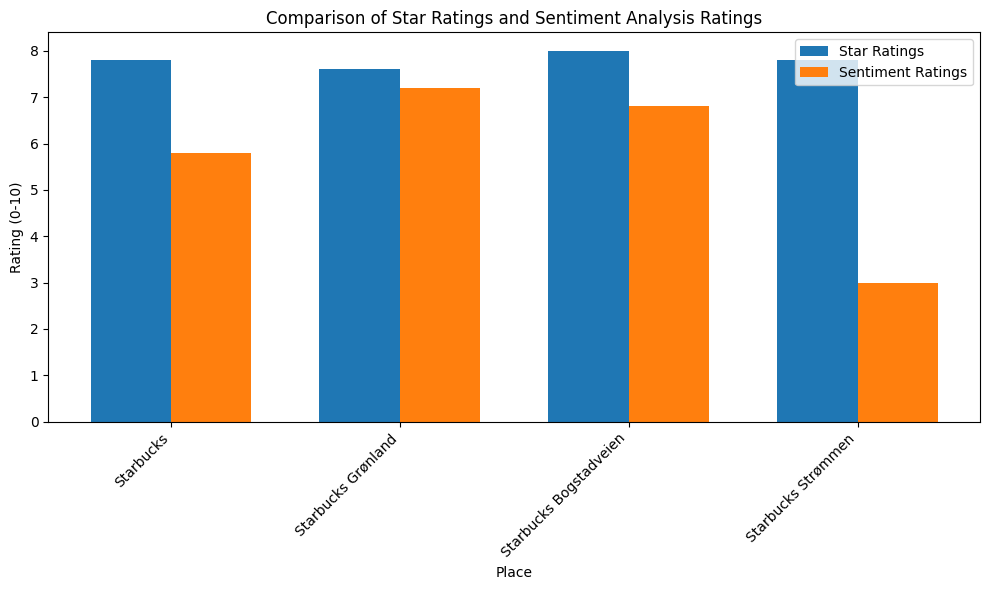

In [59]:
#visualize the rating comparison of the sentiment abalysis, versus starrating for each place
import matplotlib.pyplot as plt
import numpy as np


#normalising the starrratings to a 0-10 scale
starratings = {}
for place in places:
    starratings[place['name']] = place['rating']*2 #0-5 rating

sentiment_rating = {}
for sr in summarised_reviews.keys():
    sentiment_rating[summarised_reviews[sr]['name']] = summarised_reviews[sr]['avg_score']

places = list(starratings.keys())
star_values = [starratings[place] for place in places]
sentiment_values = [sentiment_rating.get(place, 0) for place in places]

# Create a grouped bar chart
x = np.arange(len(places))
width = 0.35  # width of each bar

fig, ax = plt.subplots(figsize=(10, 6))
bar1 = ax.bar(x - width/2, star_values, width, label='Star Ratings')
bar2 = ax.bar(x + width/2, sentiment_values, width, label='Sentiment Ratings')

# Add labels, title, and custom x-axis tick labels, etc.
ax.set_xlabel("Place")
ax.set_ylabel("Rating (0-10)")
ax.set_title("Comparison of Star Ratings and Sentiment Analysis Ratings")
ax.set_xticks(x)
ax.set_xticklabels(places, rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()

As we can see  there is some corrolation between starrrating and sentiment rating, with some outliers. This suggests that the sentiment model is able to "read between lines" and find places that are under/overrated, such as Starbucks Strømmen.

